In [1]:
# Libraries
import os
import numpy as np
import rasterio
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt


(1911, 2506, 8)

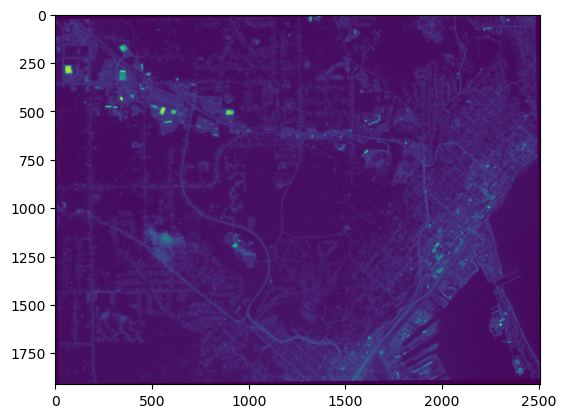

In [2]:
# Path to the Planet 8-band satellite image

image_path = r'C:/Users/tomla/OneDrive/Desktop/duluth_satellite.tif'

# Open the satellite image using rasterio
with rasterio.open(image_path) as src:
    # Read the image bands as a 3D numpy array (height, width, bands)
    image_data = src.read()
    # Transpose the image data to have bands as the first dimension
    image_data = np.transpose(image_data, (1, 2, 0))
    

# Display one band of the image
plt.imshow(image_data[..., 0])

image_data.shape


(1911, 2506)

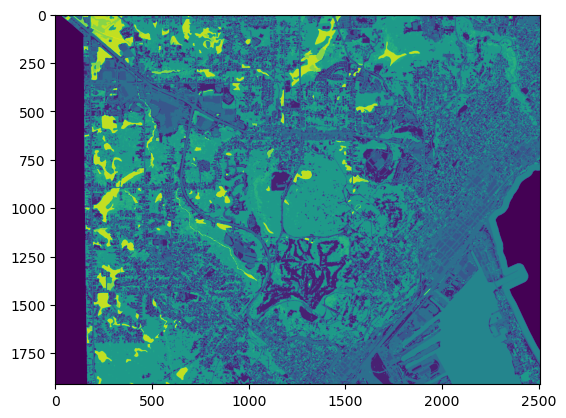

In [3]:
# Path to the ground truth raster
# Source: https://conservancy.umn.edu/handle/11299/181533

ground_truth_path = r'C:/Users/tomla/OneDrive/Desktop/ground_truth_duluth_clipped.tif'

# Open the ground truth raster using rasterio
with rasterio.open(ground_truth_path) as src:
    # Read the raster band as a 2D numpy array
    ground_truth_data = src.read(1)

# Display the Ground Truth Raster
plt.imshow(ground_truth_data)

ground_truth_data.shape


In [4]:
# Labels in the ground truth data are integers, 0 - 11, with each integer representing one class
np.unique(ground_truth_data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11], dtype=uint8)

In [5]:
# Flatten the image_data to get a 2D array (num_pixels, num_bands) from (height * width, num_bands)
flattened_image = image_data.reshape(-1, image_data.shape[-1])

# Create a StandardScaler instance to normalize the data
# Normalization can improve model performance (accuracy) 
scaler = StandardScaler()

# Fit the normalize scaler on the training data and transform both training and testing data
flattened_image_normalized = scaler.fit_transform(flattened_image)

# Flatten the ground_truth_data to get a 1D array (num_pixels,) from (height * width)
flattened_ground_truth = ground_truth_data.flatten()

# Combine the flattened_image and flattened_ground_truth into a single array, now shape (height*width, 9)
combined_data = np.column_stack((flattened_image, flattened_ground_truth))

# Sample a fraction of the data for training and testing
# Adjust the test_size parameter based on your requirements
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=1, stratify=flattened_ground_truth)

# Separate features (X) and labels (y) for training and testing sets
X_train = train_data[:, :-1]  # Features for training set
y_train = train_data[:, -1]   # Labels for training set, the last index holds the class values

X_test = test_data[:, :-1]    # Features for testing set
y_test = test_data[:, -1]     # Labels for testing set


In [6]:
# Count the occurrences of each class in the training set
# Class indices correspond to land cover types as described in: https://conservancy.umn.edu/handle/11299/181533
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Display the class counts
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {int(cls)}: {count} occurrences in the training set")

Class 0: 325138 occurrences in the training set
Class 1: 768070 occurrences in the training set
Class 2: 5515 occurrences in the training set
Class 3: 224781 occurrences in the training set
Class 4: 607835 occurrences in the training set
Class 5: 196052 occurrences in the training set
Class 6: 1331447 occurrences in the training set
Class 7: 225279 occurrences in the training set
Class 9: 23414 occurrences in the training set
Class 10: 121591 occurrences in the training set
Class 11: 2050 occurrences in the training set


In [7]:
# What is an Multi Layer Perceptron (aka a neural network): https://machinelearningmastery.com/neural-networks-crash-course/

# Create an MLPClassifier instance
#mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=20, random_state=42, verbose=1)

# A 'Deeper' MLP model with more hidden layers may have better performance
# Increase the number of max_iter to train the model to convergence
mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 100, 50, 25, 10), max_iter=10, random_state=42, verbose=1)


In [8]:
# Train the MLP model
mlp.fit(X_train, y_train)


Iteration 1, loss = 1.27932242


C:\Users\tomla\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 50, 100, 50, 25, 10), max_iter=1,
              random_state=42, verbose=1)

In [9]:
# Make predictions on the test set
predictions = mlp.predict(X_test)


In [10]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 59.23%


In [11]:
# Predict on the satellite image
# Flatten the image_data to get a 2D array (num_pixels, num_bands)
flattened_image = image_data.reshape(-1, image_data.shape[-1])

# Run the prediction
sat_prediction = mlp.predict(flattened_image)

# Reshape the predicted labels to the original image dimensions
predicted_labels = sat_prediction.reshape(image_data.shape[:-1])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


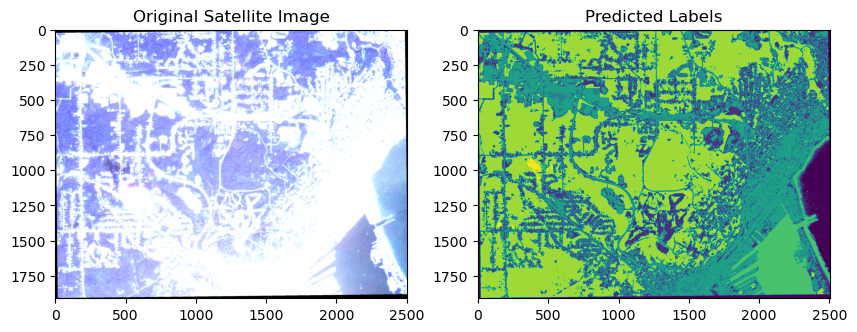

In [12]:
# Now 'predicted_labels' has the same shape as the original ground truth data

# Display the original satellite image and the predicted labels
import matplotlib.pyplot as plt

# Display original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_data[:, :, :3])  # Display only the first three bands for visualization
plt.title('Original Satellite Image')

# Display predicted labels
plt.subplot(1, 2, 2)
plt.imshow(predicted_labels, cmap='viridis')  # Adjust the colormap based on your class labels
plt.title('Predicted Labels')

plt.show()

Confusion Matrix:
[[ 133058   45443       0    3252   25229    2587  194978    1876       0
        0       0]
 [  16182  505061       0   15933  112416    2288  302657    5550       0
        0       0]
 [    108    2758       0     443    1954    1162     469       0       0
        0       0]
 [   5144   64562       0   75906  117843    4256   12461     804       0
        0       0]
 [  17602  125189       0   42314  546881    5612   21300     896       0
        0       0]
 [  24657    2609       0    1812    3239  208049    3685    1014       0
        0       0]
 [  22289  222361       0    6601   48902     629 1358203    5324       0
        0       0]
 [   2848   55024       0    1707    5223     355  208137    8305       0
        0       0]
 [   1306    5269       0      92     243     136   21980     242       0
        0       0]
 [   4654    4949       0      65     298       0  141220     803       0
        0       0]
 [      0     390       0       0      18       0   

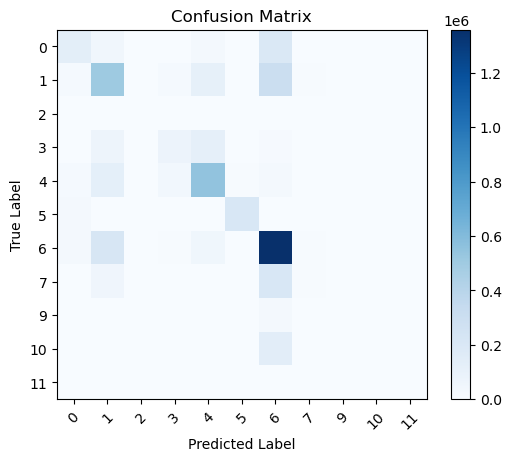

In [13]:
# Create a confusion matrix that compares our ground truth to predictions
# Class Labels: https://conservancy.umn.edu/handle/11299/181533
conf_matrix = confusion_matrix(ground_truth_data.flatten(), sat_prediction.flatten())

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Display the confusion matrix as a heatmap
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the confusion matrix
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# We see the model is not great across all classes - but can accurately classify Class 6 (Deciduous Trees), 